
# NLP Computational Discourse Analysis in Education Research Pipeline Tutorial Notebook  

This interactive notebook walks you through a **State‑of‑the‑Union (SOTU) discourse pipeline** step‑by‑step.  
Run each cell, inspect the outputs, and then adapt the code to your own qualitative data (e.g., interviews, classroom talk, policy docs).



## 0️⃣ Setup  

```bash
# Run once in a terminal or a Colab cell
pip install pandas numpy nltk spacy sentence-transformers gensim seaborn matplotlib umap-learn hdbscan
python -m spacy download en_core_web_sm
```

> **Tip**: If you're on Colab, the first cell below installs everything for you.


In [3]:

# If running on Colab, uncomment the next line
# !pip -q install pandas numpy nltk spacy sentence-transformers gensim seaborn matplotlib umap-learn hdbscan && python -m spacy download en_core_web_sm -q
%pip -q install gensim

Note: you may need to restart the kernel to use updated packages.


### 0.1 Library Imports and NLP Model Setup

This cell sets up all necessary Python libraries and NLP tools used throughout the pipeline:
- **Core Libraries**:  
  - `os`, `glob`, `re`, `json`, `warnings`, `itertools`, `math` – general-purpose utilities for file handling, regex, and logic
  - `textwrap` – used for nicely formatting long output strings (e.g., topics or entity lists)

- **Data Science Stack**:  
  - `pandas`, `numpy` – for data manipulation and matrix operations

- **Natural Language Processing**:  
  - `nltk` – for basic tokenization and stopword removal  
  - `spacy` – for POS tagging and named entity recognition  
  - `sentence-transformers` – loads a pretrained transformer model (`all-MiniLM-L6-v2`) to convert text into semantic vector embeddings  
  - `gensim` – for topic modeling using Latent Dirichlet Allocation (LDA)

- **Visualization**:  
  - `seaborn`, `matplotlib.pyplot` – for plotting semantic similarity heatmaps

The following setup is also performed:
- Downloads necessary NLTK resources (`punkt`, `stopwords`)
- Loads the lightweight English `spaCy` model (`en_core_web_sm`)
- Defines the stopword list
- Initializes the sentence embedding model for downstream semantic comparisons

Once run, this cell ensures all tools are ready for preprocessing, annotation, embedding, similarity computation, and topic modeling.


In [11]:

import os, glob, re, json, warnings, itertools, textwrap, math
import pandas as pd
import numpy as np
import nltk, spacy
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns, matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from tqdm.autonotebook import tqdm, trange

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

model = SentenceTransformer('all-MiniLM-L6-v2')

print('✅ Libraries ready')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\blerdrage\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\blerdrage\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Libraries ready


### Core NLP Functions for Preprocessing, Annotation, and Topic Modeling

This section defines modular Python functions that perform core NLP preprocessing and analysis steps on educational or political discourse data.

---

#### `preprocess_text(text: str) -> str`

- Converts input text to lowercase
- Removes all non-alphabetic characters (punctuation, numbers)
- Collapses multiple spaces into a single space

**Example**:

```python
preprocess_text("We, the PEOPLE of 2023, declare: SCIENCE matters!!")
# → 'we the people of declare science matters'

> **Why it matters**: Standardizes the text for downstream tokenization and embedding, ensuring consistent formatting across historical or messy transcripts.

---

#### 🪄 `tokenize_text(text: str) -> List[str]`

- Uses NLTK to split the cleaned text into word tokens
- Removes stopwords (common, low-information words like “the,” “and,” “of”)

**Example**:
tokenize_text("we the people of declare science matters")
# → ['people', 'declare', 'science', 'matters']

> **Why it matters**: Produces a simplified lexical form of the text that retains meaning-bearing words for thematic analysis or frequency-based modeling.

---

#### `spacy_analysis(text: str) -> Tuple[List[Tuple], List[Tuple]]`

- Runs the text through spaCy’s NLP pipeline
- Returns:
  - `pos_tags`: Part-of-speech tags (e.g., NOUN, VERB)
  - `ents`: Named entities (e.g., names, places, organizations)

**Example**:
pos_tags, ents = spacy_analysis("President Biden signed the CHIPS Act in 2022.")
# pos_tags → [('President', 'NOUN'), ('Biden', 'PROPN'), ...]
# ents → [('Biden', 'PERSON'), ('CHIPS Act', 'LAW'), ('2022', 'DATE')]


> **Why it matters**: Enables structural discourse analysis by surfacing how language is constructed (e.g., subject-verb relationships, agentive positioning) and which actors are foregrounded.

---

#### `perform_lda(tokens_list: List[List[str]], num_topics=5)`

- Builds a Gensim dictionary and corpus from the list of tokenized texts
- Applies **Latent Dirichlet Allocation (LDA)** topic modeling to identify latent themes
- Filters out rare and overly common terms when enough documents are present
- Ensures topic count doesn’t exceed vocabulary size
- Returns:
  - The trained LDA model
  - The corpus in bag-of-words format
  - The term dictionary

**Example**:
Topic 0: 0.045*"science" + 0.032*"technology" + 0.028*"research" + 0.027*"innovation"
Topic 1: 0.040*"students" + 0.036*"education" + 0.030*"teachers" + 0.022*"schools"

> **Why it matters**: LDA helps surface **emergent topics** from a collection of documents without requiring predefined codes or themes.  
> ⚠️ Safeguards are built in to skip topic modeling when the data is too small for meaningful output.

---

These functions provide the **computational backbone for discourse analysis**, enabling reproducible and scalable methods for qualitative education research—especially useful when working with large corpora like policy documents, interview transcripts, or historical texts.

### Text Processing Flow
Raw Text
   ↓
[ preprocess_text ]
   ↓
Cleaned Text
   ↓
[ tokenize_text ]             [ spacy_analysis ]
   ↓                            ↘
Tokens                     POS tags + Entities
   ↓
[ perform_lda ]
   ↓
Topics (Theme Distributions)



In [12]:

def preprocess_text(text:str)->str:
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

def tokenize_text(text:str):
    tokens = nltk.word_tokenize(text)
    return [t for t in tokens if t not in stop_words]

def spacy_analysis(text:str):
    doc = nlp(text)
    pos_tags = [(tok.text, tok.pos_) for tok in doc]
    ents = [(ent.text, ent.label_) for ent in doc.ents]
    return pos_tags, ents

def perform_lda(tokens_list, num_topics=5):
    dictionary = Dictionary(tokens_list)
    n_docs = len(tokens_list)
    if n_docs >= 5:
        dictionary.filter_extremes(no_below=2, no_above=0.8)
    if len(dictionary) < 2:
        warnings.warn('Dictionary too small for LDA; skipping.')
        return None, None, None
    corpus = [dictionary.doc2bow(t) for t in tokens_list]
    num_topics = min(num_topics, len(dictionary))
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    return lda, corpus, dictionary



## 1️⃣ Load a Sample Speech  
This is the path to your dataset folder. It should contain one or more .csv files, each representing a document (e.g., a State of the Union speech).

🛠️ Edit this path to match your own folder if you’re using different data (e.g., teacher interviews, student reflections, policy texts).

Point `TRANSCRIPTS_FOLDER` to the folder that contains your CSV files.  
Each CSV should have at least a **`transcript`** column.

### Load and Organize Your Text Corpus

This cell sets up your **data ingestion step** — reading all transcript files into memory from a specified directory.

---

#### `TRANSCRIPTS_FOLDER`

```python
TRANSCRIPTS_FOLDER = "state_of_union_data/sotu_speeches"

This setup abstracts away the complexity of file management and prepares your corpus for analysis as a unified, iterable list of documents.

In a computational qualitative research context, this structure supports:

1.Thematic comparison across documents

2. Tracing linguistic or ideological shifts over time

3. Linking metadata (e.g., year, president, policy focus) to language use

Once loaded, each document is ready for cleaning, annotation, embedding, topic modeling, or clustering — forming the foundation of your NLP workflow.


In [13]:

#@title Set path to your data folder
TRANSCRIPTS_FOLDER = "state_of_union_data/sotu_speeches"  # ← edit me

# Recursively find all CSV files in the folder (including subfolders)
csv_files = glob.glob(os.path.join(TRANSCRIPTS_FOLDER, '**', '*.csv'), recursive=True)
print(f'Found {len(csv_files)} CSV files')

# Load each CSV into a DataFrame and track the source filename
dfs = []
for fp in csv_files:
    df = pd.read_csv(fp)                        # Load the CSV as a DataFrame
    df['source_file'] = os.path.basename(fp)    # Add a new column with the filename
    dfs.append(df)                              # Append the DataFrame to the list

# Preview the first document in your corpus
dfs[0].head()


Found 239 CSV files


,date,president,title,url,transcript,source_file
0,1790-01-08,George Washington,First Annual Address to Congress,http://www.presidency.ucsb.edu/ws/index.php?pi...,Fellow-Citizens of the Senate and House of Rep...,1790-01-08_George_Washington.csv


## 2️⃣ Text Cleaning and Tokenization

This block runs basic NLP preprocessing on each document in your corpus:

What It Does
1. `preprocess_text`:

* Lowercases the text

* Removes punctuation and numbers

* Collapses multiple spaces

* Output: a cleaned, standardized string

2. `tokenize_text`:

* Tokenizes the cleaned string using NLTK

* Removes stopwords (e.g., "the", "is", "of")

* Output: a list of meaningful tokens (words)

Each transcript goes through both stages and gets two new columns added to the DataFrame:

* `clean`: the cleaned full-text version of the transcript

* `tokens`: a list of filtered word tokens*

Sample tokens: ['fellow', 'citizens', 'senate', 'house', 'representatives', 'duty', 'first', ...]

Why This Matters
This stage prepares your data for all downstream NLP work, such as:

* Semantic embedding

* Frequency analysis

* Clustering

* Topic modeling

By standardizing and tokenizing the text, you ensure that the model focuses on meaningful patterns, not formatting quirks or filler words. This preprocessing step is foundational in any computational grounded theory or discourse analysis pipeline.

In [14]:

for df in dfs:
    df['clean'] = df['transcript'].map(preprocess_text)
    df['tokens'] = df['clean'].map(tokenize_text)
print('Sample tokens:', dfs[0]['tokens'].iloc[0][:25])   # Preview first 25 tokens of the first document - sanity check


Sample tokens: ['fellow', 'citizens', 'senate', 'house', 'representatives', 'embrace', 'great', 'satisfaction', 'opportunity', 'presents', 'congratulating', 'present', 'favorable', 'prospects', 'public', 'affairs', 'recent', 'accession', 'important', 'state', 'north', 'carolina', 'constitution', 'united', 'states']


## 3️⃣ Linguistic Annotation with spaCy (POS & NER)
This block applies part-of-speech tagging and named entity recognition (NER) to a short sample of cleaned text using the `spaCy` NLP pipeline.

What This Does
`sample_text` selects the first 500 characters from the cleaned transcript of the first document.

`spacy_analysis()` applies:

1. POS tagging – labels each word with its grammatical role (e.g., NOUN, VERB, ADJ).

2. Named Entity Recognition (NER) – identifies named people, organizations, places, dates, and other entities.

Sample Output

POS tags sample: [('fellow', 'ADJ'), ('citizens', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('senate', 'NOUN'), ...]
Named entities sample: [('United States', 'GPE'), ('Congress', 'ORG')]

* POS tags help identify sentence structure and grammatical roles.

* Entities offer insight into who and what is being talked about, which is vital for actor mapping, stance analysis, or identifying discursive power structures.

Why This Matters in Qualitative Research
Linguistic annotation helps you go beyond “what topics are discussed” to explore how things are said:

* Who is given agency (subject vs. object)?

* Are students framed as active agents or passive recipients?

* How are institutions (e.g., government, schools) named and positioned?

This kind of linguistically informed coding can support critical discourse analysis, positioning theory, or narrative analysis in educational research.

In [15]:

sample_text = dfs[0]['clean'].iloc[0][:500]
pos_tags, entities = spacy_analysis(sample_text)
print('POS tags sample:', pos_tags[:10])
print('Named entities sample:', entities[:10])


POS tags sample: [('fellow', 'ADJ'), ('citizens', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('senate', 'PROPN'), ('and', 'CCONJ'), ('house', 'PROPN'), ('of', 'ADP'), ('representatives', 'NOUN'), ('i', 'PRON')]
Named entities sample: [('senate', 'ORG'), ('house of representatives', 'ORG'), ('north carolina', 'GPE'), ('the united states', 'GPE')]


## 4️⃣ Semantic Embeddings & Similarity Matrix

* This section generates **semantic vector embeddings** for each transcript and compares them using **cosine similarity** to measure how similar the speeches are in meaning.

Each document is embedded using a transformer-based model (`all-MiniLM-L6-v2`)

These embeddings represent the semantic content of the entire text—not just keywords

Useful for comparing documents that may use different words but express similar ideas

# Compute cosine similarity matrix
Cosine similarity measures how close each document is to every other document in high-dimensional space

Output is a square matrix showing pairwise similarity scores between all texts

# Visualize semantic similarity as a heatmap

The heatmap shows semantic alignment across speeches

Darker red = high similarity (same ideas/themes); darker blue = divergence

Helps identify rhetorical continuity or rupture across administrations or time periods


# Why This Matters in Educational Research
This technique enables longitudinal discourse comparison—useful for analyzing changes in:

Language around science, education, innovation, equity

Policy framing and rhetorical stance

Especially valuable when comparing documents across different eras, speakers, or contexts

For example: Do modern presidents use language about “education” and “innovation” similarly to 20th-century leaders?

You can adapt this structure for:

Comparing transcripts from interviews with different teachers

Measuring alignment between curriculum documents and standards

Clustering classroom talk by discourse similarity

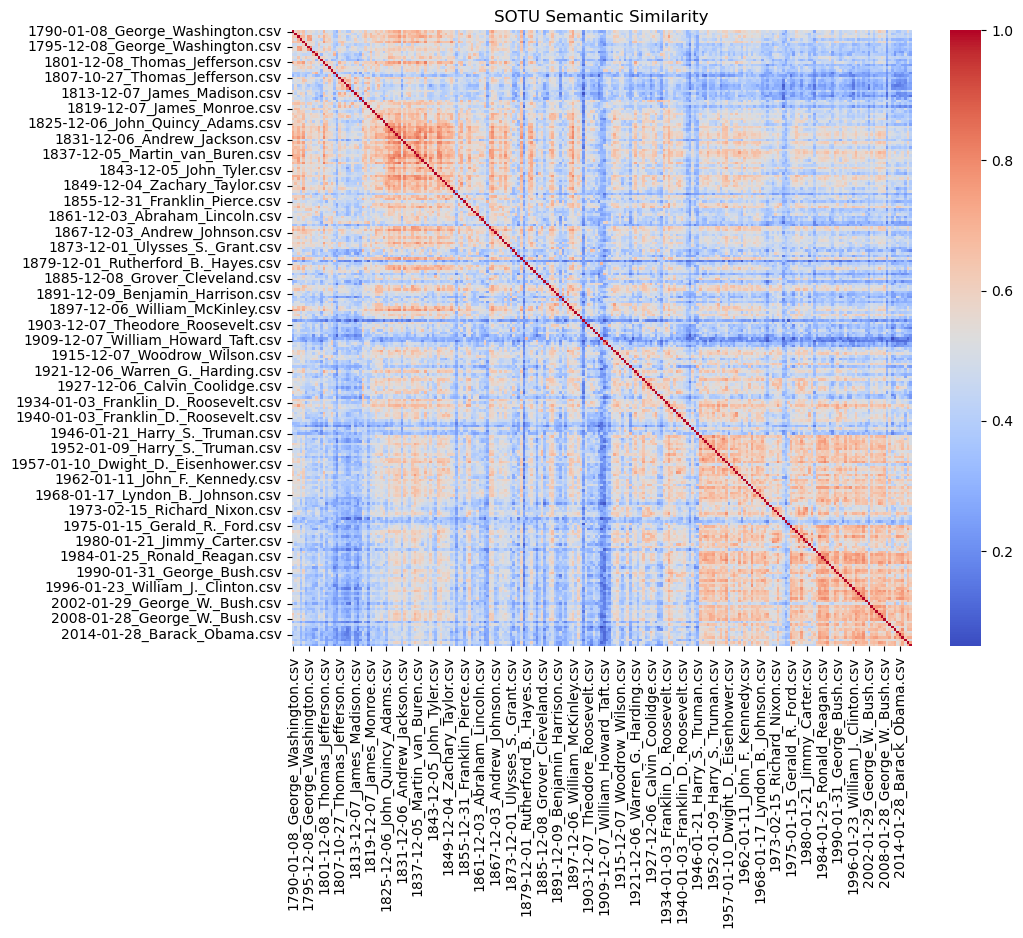

In [16]:

embeddings, names = [], []

for df in dfs:
    full_text = " ".join(df['clean']) 
    emb = model.encode(full_text)
    embeddings.append(emb)
    names.append(df['source_file'].iloc[0])  # Use the first filename as the name for this document

sim_matrix = cosine_similarity(np.vstack(embeddings))
sim_df = pd.DataFrame(sim_matrix, index=names, columns=names)

plt.figure(figsize=(10,8))
sns.heatmap(sim_df, annot=False, cmap='coolwarm')
plt.title('SOTU Semantic Similarity')
plt.show()



## 5️⃣ Topic Modeling per Speech with Latent Dirichlet Allocation(LDA)


This block applies topic modeling to the first few documents in your corpus to demonstrate how LDA can surface **latent themes** from tokenized text.

What This Does
Iterates over the first three documents in the list of DataFrames (dfs)

For each document:

Extracts its list of tokens

Passes those tokens into the perform_lda() function

If a valid LDA model is returned:

Prints the file name

Displays the top 5 keywords for each detected topic in that document


Sample Output

Topics for 1790-01-08_George_Washington.csv
Topic 0: 0.045*"duty" + 0.032*"public" + 0.028*"provision" + ...
Topic 1: 0.040*"laws" + 0.036*"commerce" + 0.030*"citizens" + ...
Each topic is represented by a weighted list of words that tend to co-occur, providing insight into underlying thematic structures in the text.

Why This Matters in Educational and Policy Discourse Research
LDA allows you to:

Move beyond surface-level keyword counts

Detect recurring concepts or rhetorical themes

Compare topic distributions across time, documents, speakers, or policy eras

For example:

Which topics dominate early vs. late 20th century speeches?

How do education-related themes cluster over time?

Are there shifts in how responsibility, innovation, or equity are framed?

⚠️ Note: LDA performs best on larger corpora. Running it on individual speeches can produce idiosyncratic or overly narrow topics, but it's still useful for demonstration and document-level exploration.


In [17]:

for df in dfs[:3]:  # demo on first 3 files
    lda, corpus, dictionary = perform_lda(df['tokens'].tolist())
    if lda:
        print(f"\nTopics for {df['source_file'].iloc[0]}")
        for i, topic in lda.print_topics(num_words=5):
            print(f"Topic {i}: {topic}")



Topics for 1790-01-08_George_Washington.csv
Topic 0: 0.008*"government" + 0.008*"states" + 0.008*"may" + 0.007*"united" + 0.007*"public"
Topic 1: 0.009*"end" + 0.008*"may" + 0.007*"united" + 0.007*"states" + 0.007*"public"
Topic 2: 0.009*"public" + 0.008*"great" + 0.007*"may" + 0.007*"best" + 0.007*"regard"
Topic 3: 0.008*"united" + 0.008*"public" + 0.007*"may" + 0.007*"measures" + 0.007*"great"
Topic 4: 0.009*"may" + 0.009*"public" + 0.008*"country" + 0.007*"measures" + 0.007*"regard"

Topics for 1790-12-08_George_Washington.csv
Topic 0: 0.009*"made" + 0.008*"public" + 0.008*"us" + 0.008*"may" + 0.007*"citizens"
Topic 1: 0.010*"made" + 0.009*"us" + 0.006*"may" + 0.006*"public" + 0.006*"means"
Topic 2: 0.010*"made" + 0.010*"us" + 0.007*"may" + 0.005*"national" + 0.005*"public"
Topic 3: 0.014*"us" + 0.009*"may" + 0.008*"made" + 0.007*"great" + 0.006*"public"
Topic 4: 0.007*"us" + 0.007*"may" + 0.007*"citizens" + 0.006*"made" + 0.006*"public"

Topics for 1791-10-25_George_Washington.csv

In [ ]:
## Follow up
You can adapt this block to:

Run LDA across the full corpus

Compare topics by year, party, or speaker

Visualize topic prevalence over time

Let me know if you’d like to add:

Interactive topic visualization (e.g., pyLDAvis)

BERTopic for more coherent results on small corpora

Sentence-level topic assignment for mixed-topic texts

Copy
Edit



## 6️⃣ Researcher Reflection

> ✏️ **Write here:** What thematic or rhetorical patterns did you notice in the similarity heatmap?  
> - Where do you see continuity or rupture in discourse?  
> - How do LDA topics align (or clash) with your qualitative reading?  
> - What further data (archival, interview, classroom) could triangulate these findings?



## 7️⃣ Extend & Adapt

- **Swap in your data**: Replace `TRANSCRIPTS_FOLDER` with a path to interview or classroom transcripts.  
- **Alternate models**: Try `sentence-transformers/all-mpnet-base-v2` or `instructor-large`.  
- **Chunk-level analysis**: Embed sentences, then cluster with UMAP + HDBSCAN to see sub‑themes.  
- **Sentiment or stance**: Add VADER, TextBlob, or transformer-based sentiment for each chunk.  
- **Visualization**: Use pyLDAvis or word clouds for topic interpretability.  

Happy exploring! 🚀
